# PubTabNet Playground
_A rule-based approach to paring tabular data from images._

### Background Information
Loosely speaking the objective of a table parsing algorithm is to convert an image of a table, extracted from a scanned document for example, into
a csv.


![1](imgs/1.png)

Tissues, Wild-type rabbits, hLPL rabbits,<br>
Perirenal fat, 1305±336, 1420±500,<br>
...


The need for a fully optical table parsing algorithm is part of a larger need for a fully optical document parsing engine. Say, for example,
there is a pdf document of a textbook, but it is just a collection of scanned images. It would be great if there was a way to search for keywords within that document. Indeed this technology does exist and has existed for quite some time. This capability can be obtained using Optical Character Recognition (OCR) which has been commonly available since the 1970s. The information age has brought with it a host of fancy Natural Language Processing (NPL) utilities such as entity recognition, text summarization, etc. Our ability to apply connect these two technologies together, i.e. applying NLP utilities on the words found within a scanned document, however, has remained an elusive target for a number of reasons that I won't go into directly. However, many of the principle roadblocks with regards to parsing tabular data from images share commonalities with those of parsing documents in general. In other words, parsing tabular data is difficult for the same sorts of reasons that parsing out the __implied structure__ of a document is difficult. "Implied structure" refers to things like "which order should the words be read in".

### Why is this a difficult task?
For the purposes of this task, there are 3 commonly observed properties that influence the ability to parse tables using traditional image processing schemes.

1. The existance of gridlines
2. The existance of sub categories
3. Abnormal angles


If gridlines are present, then the cell relationships can be very reliably determined by using an image processing library (like opencv) to detect nested parallelagrams. If gridlines are not present, then we attempt to deduce the horizontal and vertical positions that the gridlines would have by searching for columns and rows of pixels which do not intersect any labels. The existance of sub categories, however, introduces a very tricky problem. How do we determine the super-sub-category relationships? The approach laid out in this notebook does not attempt to identify these sorts of relationships. Instead, we assume a traditional $nxm$ grid and simply place each label in the nearest cell, paying no mind to the implied relationships of the super-sub categories. In "Rethinking Table Recognition using Graph Neural Networks", Qasim addresses the sub-category issue by reformulating the problem into one of relationship prediction which you can read more about here https://arxiv.org/abs/1905.13391.


Combinatorically, there are 6 categories of tables (one for each permutation of the 3 boolean attributes listed above). "Rethinking Table Recognition using Graph Neural Networks" (Qasim) offers a slightly different abstraction involving 4 categories (shown below), but the distinction between the two trains of thought are not important. In this notebook, we are specifically addressing how to deal with tables that do not have gridlines in a way that does not catastrophically fail in the presence of hierarchical rows and columns.


![4](imgs/4.PNG)<br>






### Approach
The general approach laid out in this notebook is as follows
1. Obtain bbox coordinates of words in the table using Tesseract (Google's OCR engine)
2. Iterate through each column and row of pixels, counting up the number of labels that the column/row intersects
3. Identify spans of columns/rows of pixels which intersect significantly fewer labels than their neighbors (call these boundaries)
4. Use the boundaries determined in step 3 to construct imaginary gridlines



### Data
PubTabNet consists of images of tables along with the XML used to generate each image. We will utilize the XML to determine the actual number of rows and columns which should have been detected within the image and compare that to the predicted grid.

# The code

In [1]:
from pathlib import Path

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from PubTabNetDataset import PubTabNet
from TesseractUtils import im_to_data, scale

PubTabNetDataset and TesseractUtils are custom modules that make the code a bit more consice. Primarily they handle loading the dataset and all of the OCR processing and output formatting. They can be found in the repo.
### Load the data

In [4]:
data_dir = Path(r"C:\Users\stans\Documents\Projects\Datasets\pubtabnet.tar\pubtabnet\pubtabnet")
train_dir = data_dir / "train"
target_path = data_dir / "PubTabNet_2.0.0.jsonl"
TrainDataset = PubTabNet(train_dir, target_path)

### Utility Functions

In [5]:
COLORS = {
    'black':(0,0,0),
    'red':(150,0,0),
    'green':(0,150,0),
    'blue':(0,0,150)
}

def draw(im, bbox, color='black'):
    im = np.array(im)  # in case it is in PIL format
    x, y, w, h = bbox
    W,H,_ = im.shape
    
    if isinstance(color, str):
        color = COLORS[color]
    
    pt1 = (x, y)
    pt2 = (x+w, y+h)
    return cv2.rectangle(im, pt1=pt1, pt2=pt2,
        color=color, thickness=1
    )

### Inspecting the data

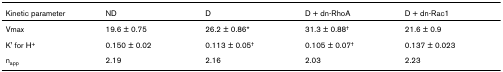

In [6]:
im, trg = TrainDataset[0]
im

In [7]:
trg[0]

{'col_start': 0,
 'col_end': 0,
 'row_start': 0,
 'row_end': 0,
 'is_head': True,
 'is_body': False,
 'raw': '<thead><tr><td></td>',
 'text': ('Kinetic parameter',),
 'bbox': [5, 9, 66, 19]}

Essentially we have the bounding box of each cell in terms of the pixel coordinates and the cell coordinate, and whether or not the cell is part of the header.

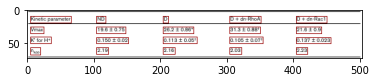

In [8]:
cp = im.copy()
for cell in trg:
    x, y, x2, y2 = cell["bbox"]
    w = x2 - x
    h = y2 - y
    cp = draw(cp, (x,y,w,h), "red")
plt.imshow(cp)

### Grid Detect Algroithm
In this section we go through the first few steps of the Grid Detection algorithm in order to establish some intuition behind the approach. We will start with the output of OCR


#### Extracting the coordinates of data values and labels
The following `im_to_data` function is defined in a separate script which is included in the repo. The primary function is to reformat the raw text output from Tesseract into a dataframe. `scaling_factor` takes care of scaling up the image (for better OCR results) and scaling the resulting bboxes back down to the original size.

In [9]:
df = im_to_data(im, scaling_factor=3)
df.head()

,index,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,4,5,1,1,1,1,1,6,10,22,6,94.0,Kinetic
1,5,5,1,1,1,1,2,31,11,34,6,95.0,parameter
2,6,5,1,1,1,1,3,100,8,16,10,86.0,ND
3,7,5,1,1,1,1,4,206,8,3,10,30.0,BD
4,8,5,1,1,1,1,5,305,10,5,6,73.0,0


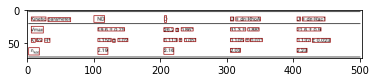

In [10]:
# show the bboxes for fun
cp = im.copy()
for bbox in df[["left", "top", "width", "height"]].values:
    cp = draw(cp, bbox, "red")
plt.imshow(cp)

#### Quantify Intersections
The general strategy here is to try and segment the image vertically and horizontally, using the slices devoid of any text as markers for a column/row boundary. To accomplish this, we'll use the boxes returned by tesseract to identify regions of text, then examine the vertical and horizontal slices of the mask to try and detect gaps in content. The following cells will plot out the density of text along the vertical and horizontal axes of the image, showing a very clear signal that can be used to mark our boundaries. Specifically, the peaks in the graph correspond to the centers of a row or column, while the low points indicate where the gridlines would be drawn if they were visible.

In [11]:
mask = np.zeros(im.size)
for bbox in df[['left', 'top', 'width', 'height']].values:
    x,y,w,h = bbox
    mask[x:x+w,y:y+h]=1

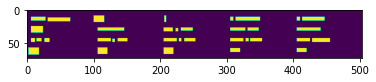

In [12]:
plt.imshow(mask.T)

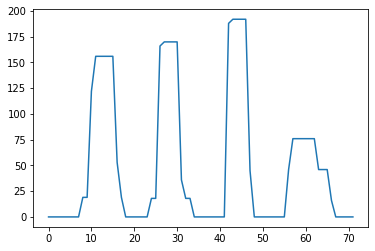

In [13]:
# vertical text distribution
plt.plot(mask.sum(axis=0))

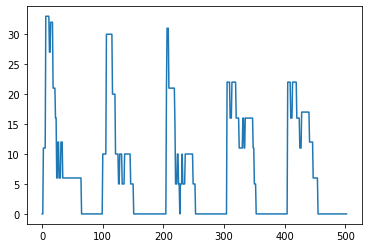

In [14]:
# horizontal text distribution
plt.plot(mask.sum(axis=1))

### Grid Detect Algorithm
The following function attempts to detect the minima in those two plots in order to determine the vertical and horizontal locations at which the table should be split


In [15]:
def grid_detect(
    im,
    v_thresh=0.08,
    h_thresh=0.2,
    min_v_gap = 0.5, # percentage of average word height
    min_h_gap = 2, # percentage of average word height
):
    """
    im <PIL.Image or imarray>: Image of a table
        
    v_thresh <float> (0.1): Threshold for considering a row of pixels to be considered
        a vertical boundary in the grid. Higher values mean fewer rows.
        
    h_thresh <float> (0.1): Threshold for considering a column of pixels to be considered
        a horizontal boundary in the grid. Higher values mean fewer columns.
    """
    # use Tesseract to find all words
    df = im_to_data(im, scaling_factor=4)
    boxes = df[['left', 'top', 'width', 'height']].values
    avg_word_height = boxes[:,3].min()
    min_v_gap *= avg_word_height
    min_h_gap *= avg_word_height

    # create a word mask from tesseract bboxes
    mask = np.zeros(im.size)
    for bbox in boxes:
        x,y,w,h = bbox
        mask[x:x+w,y:y+h]=1

    v_density = mask.sum(axis=0)/max(mask.sum(axis=0))
    h_density = mask.sum(axis=1)/max(mask.sum(axis=1))
    
    # scale the density vectors so that the mean is equal to 0.2
    # this makes the thresholds directly related to the average density
    v_density = v_density / (np.mean(v_density)*4)
    h_density = h_density / (np.mean(h_density)*4)
    
    
    # move down the image and record spans which exceed the threshold for being considered a row
    grid_y = []
    to_del = set()
    y=0
    out=True
    for y,val in enumerate(v_density):
        if val>v_thresh and out:
            out=False
            if len(grid_y)==0 or y - grid_y[-1][-1] > min_v_gap:
                grid_y.append([y])
            else:
                grid_y[-1] = [grid_y[-1][0]]
        if val < v_thresh and not out:
            grid_y[-1].append(y)
            out = True
        if not out:  # inside of a peak
            if val > 1.5:
                to_del.add(len(grid_y)-1)
    
    
    # expand to fill
    grid_y[0][0]=0
    grid_y[-1][1]=im.size[1]-1
    for i in range(len(grid_y)-1):
        x1 = grid_y[i][1] # end of this
        x2 = grid_y[i+1][0] # begining of next
        m = int((x1+x2)/2)
        grid_y[i][1]=m
        grid_y[i+1][0]=m
    
    grid_x = []
    to_del = set()
    x=0
    out=True
    for x,val in enumerate(h_density):
        if val>h_thresh and out:
            out = False
            if len(grid_x)==0 or x - grid_x[-1][-1] > min_h_gap:
                grid_x.append([x])
            else:
                grid_x[-1] = [grid_x[-1][0]]
        if not val>h_thresh and not out:
            grid_x[-1].append(x)
            out = True
        if not out:  # inside of a peak
            if val > 1.5:
                to_del.add(len(grid_x)-1)
    
    # expand to fill
    grid_x[0][0]=0
    grid_x[-1][1]=im.size[0]-1
    for i in range(len(grid_x)-1):
        x1 = grid_x[i][1] # end of this
        x2 = grid_x[i+1][0] # begining of next
        m = int((x1+x2)/2)
        grid_x[i][1]=m
        grid_x[i+1][0]=m
    
    grid = []
    for y in grid_y:
        y1,y2 = y
        for x in grid_x:
            x1,x2 = x
            grid.append([x1,y1,x2-x1,y2-y1])
    return grid, df

In [16]:
im, trg = TrainDataset[5]

In [17]:
grid, df = grid_detect(im)

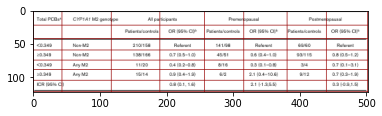

In [18]:
# show the bboxes for fun
cp = im.copy()
for bbox in grid:
    cp = draw(cp, bbox, "red")
plt.imshow(cp)

### Performance
That looks pretty good. But we need a metric to quantify the goodness. IBM has kindly provided a metric for just this purpose, but it doesn't quite fit the bill for this approach. The reason being, we kind of cheated. I did not pay any attention to the hierarchical issue mentioned in the introduction. Instead, the approach was to assume a matrix-like grid, which kind of ignores the spirit of the problem of _understanding_ or extracting the meaning of the table. But, it is suitable for my needs. This means we need to make our own metric.

The following metric determines the number of rows and columns that should be detected, and compares it to the number of columns and rows that were detected.

In [19]:
def custom_metric(y_pred, y_actual):
    n_cols_actual = max([x["col_end"] for x in y_actual])+1
    n_rows_actual = max([x["row_end"] for x in y_actual])+1
    
    n_cols_pred = 0
    y_end = y_pred[0][-1]
    for bbox in y_pred:
        if bbox[1] >= y_end:
            break
        n_cols_pred += 1
        
    n_rows_pred = len(y_pred)/n_cols_pred
    return (abs(n_rows_pred - n_rows_actual)+abs(n_cols_actual-n_cols_pred))

In [20]:
scores = []
wrong = []
for i in tqdm(range(1000)):
    try:
        im, trg = TrainDataset[i]
        grid, df = grid_detect(im)
        loss = custom_metric(grid, trg)
        if loss:
            wrong.append(i)
        scores.append(loss)
    except:
        print(f"error on img {i}")

 46%|███████████████████████████████████████████████████████████████▏                                                                        | 465/1000 [07:31<05:59,  1.49it/s]

error on img 464


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 785/1000 [13:12<01:34,  2.27it/s]

error on img 784


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 823/1000 [13:52<05:04,  1.72s/it]

error on img 822


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [16:48<00:00,  1.01s/it]


In [21]:
print(sum(scores)/len(scores))

3.990972918756269


In [22]:
len(wrong)/len(scores)

0.7873620862587764

This metric quantifies the ability to determine the correct number of rows and columns in the table. While this is not directly representative of the objective, due to the mechanism by which the model determines what is considered a boundary, it is very indicative of the ability to determine the correct grid. On average this algorithm fails to detect a boudary, or detects a boundary that should not exist, roughly 4 times per image. The percentage of tables which were parsed perfectly correct are 22.3%. This 22.3% is an upper bound on accuracy of this method. Issues relating to OCR accuracy and edge cases regarding incorrect placement of segmentations will drive this down further. Because of this, we can only say that the accuracy is no greater than 22.3%, but inspecting the failure points shows that despite the relative inability to perfectly parse tables, the result is typically pretty close to perfect. 

The following comparisons to previous research come with the massive asterisk that "Rethinking Table Recognition using Graph Neural Networks" uses a completely different dataset. One that is generated on the fly without the limitations relating to low resolution that we have in PubTabNet. With that said, Qasim reports an accuracy of 55.9% on (category 3) tables (whereas our model achieves 23.7%), and 94.7% on (category 2) tables (whereas our model achieves 20.3%). One interesting point we can draw from this is that the rule-based methodology is relatively invariant to the existance of hierarchical grouping, but nevertheless performs worse than the DGCNN model proposed by Qasim in both cases. Notably, however, it does outperform FCNN and GravNet models by 12% and 9% respectively for (category 3) tables.

### Future Research
The next obvious step is to perform a grid search over the 4 hyper-parameters (`v_thresh`, `h_thresh`, `min_v_gap`, `min_h_gap`) to find the optimal values. This will take a significant amount of time as Tesseract takes a few seconds to process each image, but is a very straightforward task. Another area for improvement is to add some logic to handle slanted tables (category 4). This dataset does not include many tables which that would apply to, but it would be a welcome addition. However, rule-based approaches, such as the one outlined here, are historically sub-par. It is likely more advantageous to pursue a graph based relationship detection scheme. This has the promise of dealing with hierarchical relationships within the table, which is much closer to the ultimate goal of extracting the knowledge encoded within.

### Points of Failure
Here are some of the tables that the algorithm failed to parse correctly.

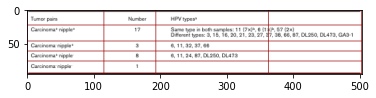

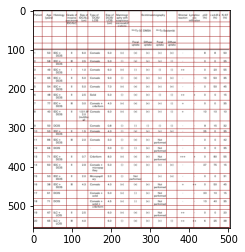

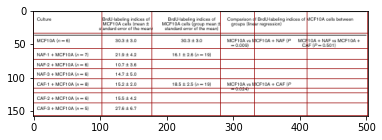

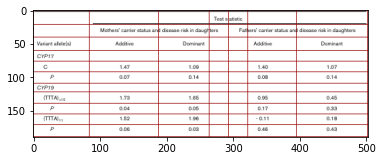

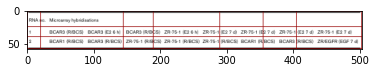

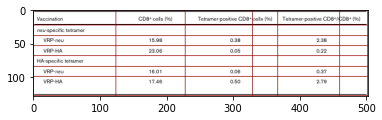

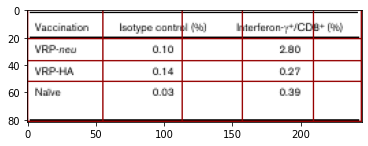

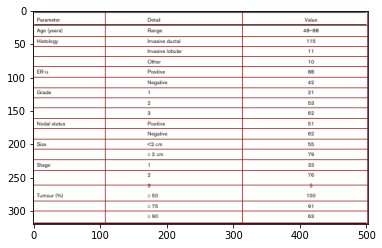

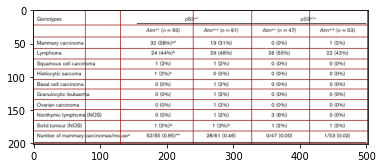

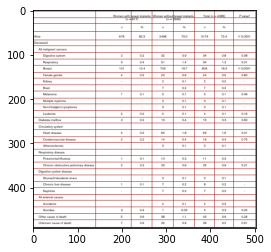

In [23]:
for i in wrong[:10]:
    im, trg = TrainDataset[i]
    grid, df = grid_detect(im)
    # show the bboxes for fun
    cp = im.copy()
    for bbox in grid:
        cp = draw(cp, bbox, "red")
    plt.imshow(cp)
    plt.show()

In [24]:
c2 = []
c3 = []
for i in tqdm(range(1000)):
    try:
        im, trg = TrainDataset[i]
        for t in trg:
            if t["col_end"] - t["col_start"] > 0:
                c3.append(i)
                break
            elif t["row_end"] - t["row_start"] > 0:
                c3.append(i)
                break
        else:
            c2.append(i)
                
    except:
        print(f"error on img {i}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1712.51it/s]


In [27]:
c3_perfect = sum([(i not in wrong) for i in c3])
c2_perfect = sum([(i not in wrong) for i in c2])

In [29]:
c3_perfect/len(c3)

0.23692307692307693

In [30]:
c2_perfect/len(c2)

0.20444444444444446